# Domain Classifier (dSprites)

This notebook builds domain classifiers and conduct related experiments.

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import scipy.io
from math import ceil
from copy import deepcopy
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras import optimizers

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_confusion_matrix
from scipy.stats import ks_2samp, binom_test, chisquare, chi2_contingency, anderson_ksamp
from scipy.spatial import distance

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Mount drive (if needed)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
# Run utility functions
%run drive/MyDrive/Colab\ Notebooks/MPhil\ Prototype/Utilities.ipynb

## Load Dataset

In [5]:
# Load dataset, split into train test
path = 'drive/MyDrive/dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz'
x_train, x_test, y_train, y_test, c_train, c_test = load_dsprites(path, 100000, train_size=0.85, class_index=1)

Training samples: 85000
Testing samples: 15000


In [6]:
# Reshape to appropriate shift input
# It is noteworthy that for efficiency, we represent the images as only 2 dimension
# when we preprocessing (number of instances/ batch size * flatten size).
# When visualising back the image, we need to reshape it back to the original dimension
ORIGINAL_SHAPE = x_train.shape[1:] # constant hold the image original shape
x_train_flatten = deepcopy(x_train.reshape(x_train.shape[0], -1))
x_test_flatten = deepcopy(x_test.reshape(x_test.shape[0], -1))

## Domain Classifiers Dataset

Here we note that label 0 means that it comes from training and label 1 means that it comes from real-world.

### Gaussian Shift
Real world data are assumed to get some gaussian shift.

#### Large

In [6]:
# Clean data
x_clean, y_clean = x_train_flatten, y_train

# Altered data
shift = "large_gn_shift_1.0"
x_altered, y_altered = apply_shift(deepcopy(x_train_flatten), y_train, shift, ORIGINAL_SHAPE) 

Large GN shift


In [12]:
x_train_new, y_train_new, _, x_test_new, y_test_new, _ = generate_domain_classifier_data(
    x_clean, y_clean, x_altered, y_altered, delta=0.8
)

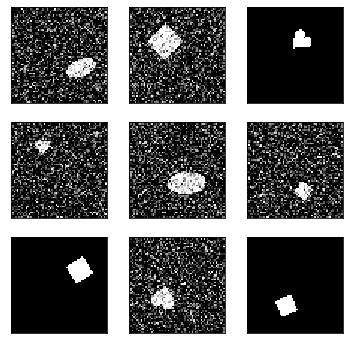

In [37]:
# Check image (looks good, stacking algorithms perfect)
show_images_grid(x_train_new.reshape([-1, 64, 64]), num_images=9)

#### Medium

In [58]:
# Clean data
x_clean, y_clean = x_train_flatten, y_train

# Altered data
shift = "medium_gn_shift_1.0"
x_altered, y_altered = apply_shift(deepcopy(x_train_flatten), y_train, shift, ORIGINAL_SHAPE) 

Medium GN Shift


In [59]:
x_train_new_gm, y_train_new_gm, _, x_test_new_gm, y_test_new_gm, _ = generate_domain_classifier_data(
    x_clean, y_clean, x_altered, y_altered, delta=0.8
)

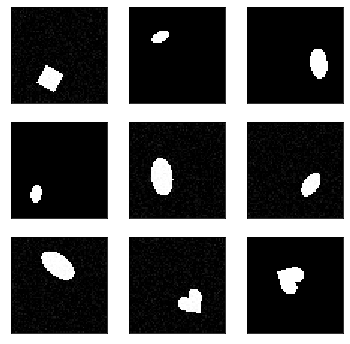

In [60]:
# Check image (looks good, stacking algorithms perfect)
show_images_grid(x_train_new_gm.reshape([-1, 64, 64]), num_images=9)

#### Small

In [7]:
# Clean data
x_clean, y_clean = x_train_flatten, y_train

# Altered data
shift = "small_gn_shift_1.0"
x_altered, y_altered = apply_shift(deepcopy(x_train_flatten), y_train, shift, ORIGINAL_SHAPE) 

Small GN Shift


In [8]:
x_train_new_gs, y_train_new_gs, _, x_test_new_gs, y_test_new_gs, _ = generate_domain_classifier_data(
    x_clean, y_clean, x_altered, y_altered, delta=0.8
)

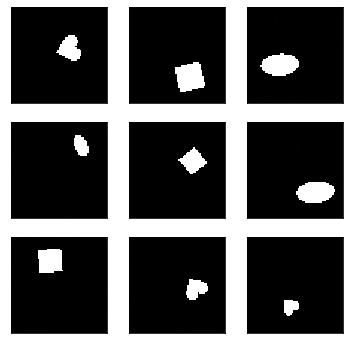

In [10]:
# Check image (looks good, stacking algorithms perfect)
show_images_grid(x_train_new_gs.reshape([-1, 64, 64]), num_images=9)

### Image Shift
Real world data are assumed to get image shift.

#### Large

In [38]:
# Clean data
x_clean, y_clean = x_train_flatten, y_train

# Altered data
shift = "large_img_shift_1.0"
x_altered_img, y_altered_img = apply_shift(deepcopy(x_train_flatten), y_train, shift, ORIGINAL_SHAPE) 

Large image shift


In [39]:
x_train_new_img, y_train_new_img, _, x_test_new_img, y_test_new_img, _ = generate_domain_classifier_data(
    x_clean, y_clean, x_altered_img, y_altered_img, delta=0.8
)

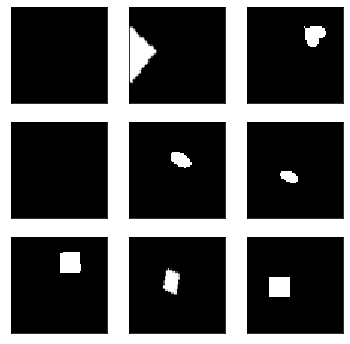

In [41]:
# Check image (looks good, stacking algorithms perfect)
show_images_grid(x_train_new_img.reshape([-1, 64, 64]), num_images=9)

#### Medium

In [18]:
# Clean data
x_clean, y_clean = x_train_flatten, y_train

# Altered data
shift = "medium_img_shift_1.0"
x_altered_im, y_altered_im = apply_shift(deepcopy(x_train_flatten), y_train, shift, ORIGINAL_SHAPE) 

Medium image shift


In [19]:
x_train_new_im, y_train_new_im, _, x_test_new_im, y_test_new_im, _ = generate_domain_classifier_data(
    x_clean, y_clean, x_altered_im, y_altered_im, delta=0.8
)

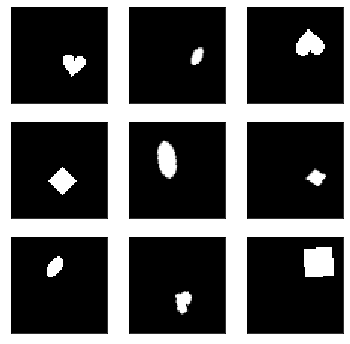

In [20]:
# Check image (looks good, stacking algorithms perfect)
show_images_grid(x_train_new_im.reshape([-1, 64, 64]), num_images=9)

#### Small

In [21]:
# Clean data
x_clean, y_clean = x_train_flatten, y_train

# Altered data
shift = "small_img_shift_1.0"
x_altered_is, y_altered_is = apply_shift(deepcopy(x_train_flatten), y_train, shift, ORIGINAL_SHAPE) 

Small image shift


In [22]:
x_train_new_is, y_train_new_is, _, x_test_new_is, y_test_new_is, _ = generate_domain_classifier_data(
    x_clean, y_clean, x_altered_is, y_altered_is, delta=0.8
)

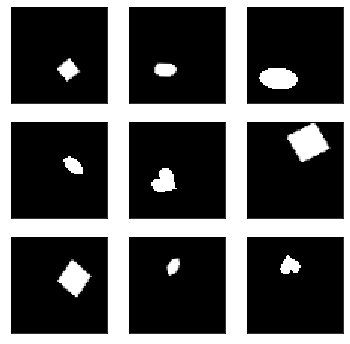

In [23]:
# Check image (looks good, stacking algorithms perfect)
show_images_grid(x_train_new_is.reshape([-1, 64, 64]), num_images=9)

## Build Domain Classifiers

In this section, we will build domain classifiers for detecting whether image comes from training or real-world (0 or 1). We will fit the datasets to the domain classifiers.

### Baseline

The baseline is the no shift. We hypothesise that the classification accuracy would be 50% since training and testing (real world) data is the same.

In [14]:
# Trained using the same data, not altered in any way
x_train_new, y_train_new, _, x_test_new, y_test_new, _ = generate_domain_classifier_data(
    deepcopy(x_train_flatten), deepcopy(y_train), 
    deepcopy(x_train_flatten), deepcopy(y_train), delta=0.8
)

In [15]:
lr = LogisticRegression()
lr.fit(x_train_new, y_train_new)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

         0.0       1.00      0.50      0.67     34000
         1.0       0.00      0.00      0.00         0

    accuracy                           0.50     34000
   macro avg       0.50      0.25      0.33     34000
weighted avg       1.00      0.50      0.67     34000



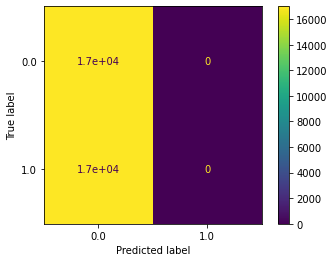

In [16]:
y_test_pred = lr.predict(x_test_new)
print(classification_report(y_test_pred, y_test_new))
plot_confusion_matrix(lr, x_test_new, y_test_new)
plt.show()

**Observation**: We observe that the logistic regression cannot distinguish between classes as expected. This shows that when there is no shift, the accuracy of the domain classifier will be roughly 50%.

### Gaussian Shift

#### Large

In [52]:
## Simple logistic regression for sanity check
lr = LogisticRegression()
lr.fit(x_train_new, y_train_new)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     17000
         1.0       1.00      1.00      1.00     17000

    accuracy                           1.00     34000
   macro avg       1.00      1.00      1.00     34000
weighted avg       1.00      1.00      1.00     34000



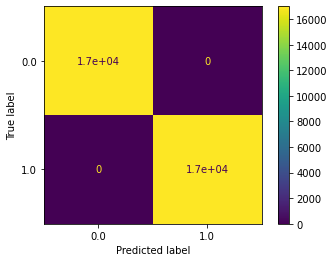

In [54]:
y_test_pred = lr.predict(x_test_new)
print(classification_report(y_test_pred, y_test_new))
plot_confusion_matrix(lr, x_test_new, y_test_new)
plt.show()

#### Medium

In [61]:
## Simple logistic regression for sanity check
lr = LogisticRegression()
lr.fit(x_train_new_gm, y_train_new_gm)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     16999
         1.0       1.00      1.00      1.00     17001

    accuracy                           1.00     34000
   macro avg       1.00      1.00      1.00     34000
weighted avg       1.00      1.00      1.00     34000



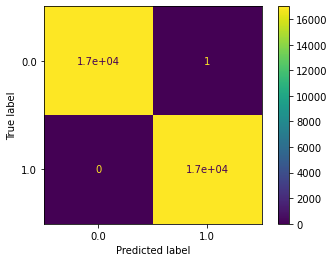

In [62]:
y_test_pred = lr.predict(x_test_new_gm)
print(classification_report(y_test_pred, y_test_new_gm))
plot_confusion_matrix(lr, x_test_new_gm, y_test_new_gm)
plt.show()

#### Small

In [11]:
## Simple logistic regression for sanity check
lr = LogisticRegression()
lr.fit(x_train_new_gs, y_train_new_gs)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

         0.0       0.99      0.98      0.98     17103
         1.0       0.98      0.99      0.98     16897

    accuracy                           0.98     34000
   macro avg       0.98      0.98      0.98     34000
weighted avg       0.98      0.98      0.98     34000



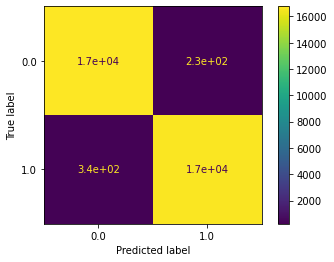

In [12]:
y_test_pred = lr.predict(x_test_new_gs)
print(classification_report(y_test_pred, y_test_new_gs))
plot_confusion_matrix(lr, x_test_new_gs, y_test_new_gs)
plt.show()

**Observation**: We observed that the domain classifier can detect Gaussian shift very well in all cases.

### Image Shift

#### Large

In [56]:
## Simple logistic regression for sanity check
lr = LogisticRegression()
lr.fit(x_train_new_img, y_train_new_img)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

         0.0       0.92      0.72      0.81     21686
         1.0       0.64      0.89      0.75     12314

    accuracy                           0.78     34000
   macro avg       0.78      0.81      0.78     34000
weighted avg       0.82      0.78      0.79     34000



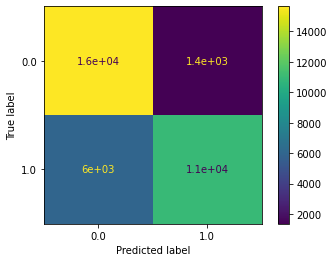

In [57]:
y_test_pred = lr.predict(x_test_new_img)
print(classification_report(y_test_pred, y_test_new_img))
plot_confusion_matrix(lr, x_test_new_img, y_test_new_img)
plt.show()

#### Medium

In [38]:
## Simple logistic regression for sanity check
lr = LogisticRegression()
lr.fit(x_train_new_im, y_train_new_im)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

         0.0       0.75      0.60      0.67     21074
         1.0       0.51      0.67      0.58     12926

    accuracy                           0.63     34000
   macro avg       0.63      0.64      0.62     34000
weighted avg       0.66      0.63      0.63     34000



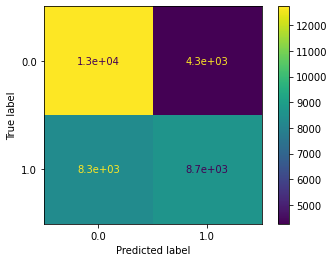

In [39]:
y_test_pred = lr.predict(x_test_new_im)
print(classification_report(y_test_pred, y_test_new_im))
plot_confusion_matrix(lr, x_test_new_im, y_test_new_im)
plt.show()

In [40]:
# Statistical test (binomial)
errors = np.count_nonzero(y_test_new_im - y_test_pred)
successes = len(y_test_pred) - errors
pvalue = test_shift_bin(successes, len(y_test_pred), 0.5)
alpha = 0.05
if pvalue < alpha:
    print(f"As p-value < {alpha}, reject null hypothesis, suggesting that classifier can distinguished.")
else:
    print(f"As p-value > {alpha}, cannot reject null hypothesis, suggesting that classifier may not be able to distinguished.")


As p-value < 0.05, reject null hypothesis, suggesting that classifier can distinguished.


#### Small

In [27]:
## Simple logistic regression for sanity check
lr = LogisticRegression()
lr.fit(x_train_new_is, y_train_new_is)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

         0.0       0.53      0.52      0.52     17475
         1.0       0.50      0.52      0.51     16525

    accuracy                           0.52     34000
   macro avg       0.52      0.52      0.52     34000
weighted avg       0.52      0.52      0.52     34000



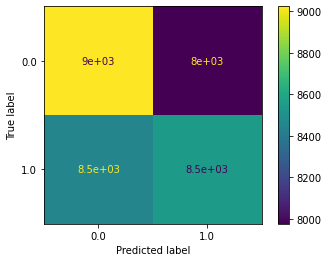

In [35]:
y_test_pred = lr.predict(x_test_new_is)
print(classification_report(y_test_pred, y_test_new_is))
plot_confusion_matrix(lr, x_test_new_is, y_test_new_is)
plt.show()

In [36]:
# Statistical test (binomial)
errors = np.count_nonzero(y_test_new_is - y_test_pred)
successes = len(y_test_pred) - errors
pvalue = test_shift_bin(successes, len(y_test_pred), 0.5)
alpha = 0.05
if pvalue < alpha:
    print(f"As p-value < {alpha}, reject null hypothesis, suggesting that classifier can distinguished.")
else:
    print(f"As p-value > {alpha}, cannot reject null hypothesis, suggesting that classifier may not be able to distinguished.")


As p-value < 0.05, reject null hypothesis, suggesting that classifier can distinguished.


**Observation**: Domain classifier can detect image shift, although not as good as gaussian shift. Additionally, for small image shifts, it cannot really detect the shifts.